# Harris and RANSAC

In this notebook we implemented Harris Detector to find the corners of an image. Then, we matched points for different views of the same element and used RANSAC to help create a single image of all perspective adjusted.

In [38]:
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt

## Corner Detector

We start by implementing the Harris Corner Detector. The Harris Corner Detector identifies points in an image where the intensity changes significantly in all directions. These points often correspond to corners.

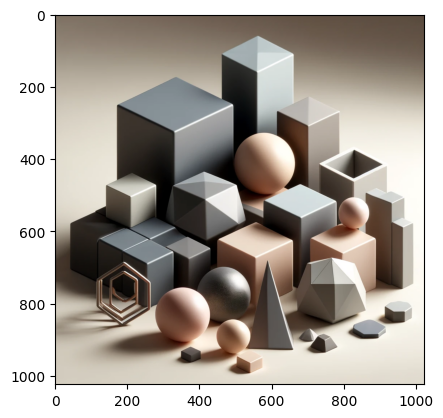

In [23]:
img = cv2.imread('img/objetos_3d.webp') 
impb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 

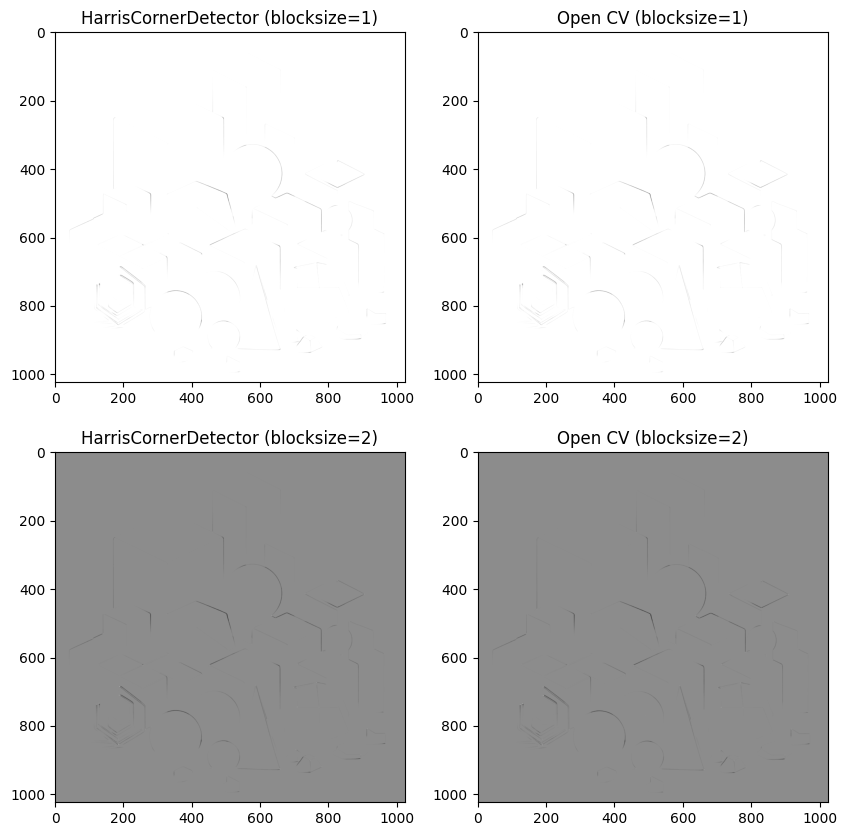

In [24]:
def HarrisCornerDetector(image, blockSize, ksize=3, k=0.05):
    """
    Detects corners in an image using the Harris Corner Detector algorithm.

    Args:
        image (numpy.ndarray): Input image in grayscale.
        blockSize (int): Size of the neighborhood considered for corner detection.
        ksize (int, optional): Size of the Sobel filter used to calculate horizontal and vertical gradients. Defaults to 3.
        k (float, optional): Free parameter of the Harris detector equation. Defaults to 0.05.

    Returns:
        numpy.ndarray: Binary image with the corner score for each pixel.
    """

    nlin, ncol = image.shape
    image = np.float32(image)
    image = image/255.0

    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)

    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy

    Rresult = np.zeros((nlin, ncol))

    for lin in range(blockSize, nlin-blockSize):
        for col in range(blockSize, ncol-blockSize):

            Ix2_block = Ix2[lin :lin+blockSize, col: col+blockSize ]
            Iy2_block = Iy2[lin :lin+blockSize, col: col+blockSize ]
            Ixy_block =  Ixy[lin :lin+blockSize, col: col+blockSize ]

            Sxx = Ix2_block.sum()
            Syy = Iy2_block.sum()
            Sxy = Ixy_block.sum()

            det = Sxx*Syy - Sxy**2
            trace = Sxx + Syy

            R = det - k*(trace**2)

            Rresult[lin, col] = R

    return Rresult

fig, ax = plt.subplots(2, 2, figsize=(10,10))

for col in [1,2]:
        
    Rresult = HarrisCornerDetector(impb, col, 3)
    Rresult_normalized = cv2.normalize(Rresult, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    RresultCV = cv2.cornerHarris(impb, col, 3, 0.05) 

    ax[col-1,0].imshow(Rresult_normalized, cmap='gray')
    ax[col-1,0].set_title(f"HarrisCornerDetector (blocksize={col})")
    ax[col-1,1].imshow(RresultCV, cmap='gray')
    ax[col-1,1].set_title(f"Open CV (blocksize={col})")

To identify the actual corners, we'll refine the Non-Maximal Suppression to pinpoint the maximum points that represent the corners.

Text(0.5, 1.0, 'goodFeaturesToTrack')

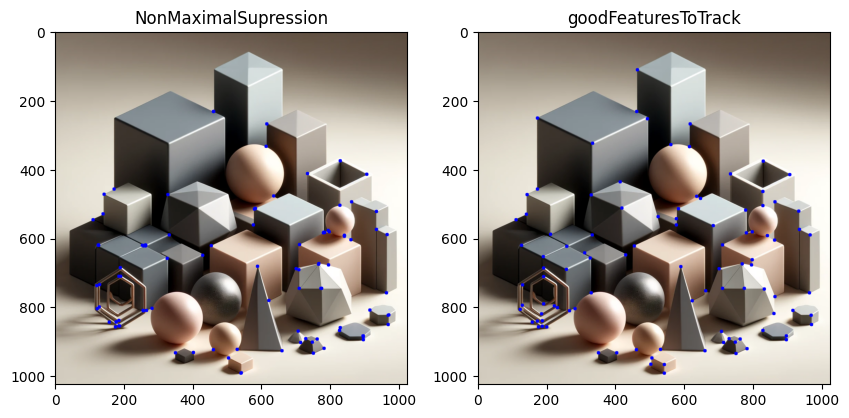

In [26]:
def NonMaximalSupression(im, maxCorners=100, window_size=3):
    """
    Non-Maximal Suppression to find maximum points in a given window size.

    Args:
        im (ndarray): Input image.
        maxCorners (int): Maximum number of corners to return. Default is 100.
        window_size (int): Size of the window used for non-maximal suppression. Default is 3.

    Returns:
        list: List of (x, y) coordinates of the maximum points.

    """
    im = im.copy()
    nl, nc = im.shape

    max_coords = []

    for lin in range(window_size, nl-window_size):
        for col in range(window_size, nc-window_size):
            
            window = im[lin -  window_size // 2: lin +  window_size // 2 + 1, col -  window_size // 2: col +  window_size // 2 + 1]
            
            if im[lin, col] == np.max(window) and im[lin, col] >= np.max(im) *0.05: 
                max_coords.append((lin, col, im[lin, col]))

    max_coords = sorted(max_coords, key=lambda x: x[2], reverse=True)[:maxCorners]

    return [(lin, col) for lin, col, _ in max_coords]


# Non Maximal Supression 
features_img = cv2.imread('img/objetos_3d.webp')
features =  NonMaximalSupression(Rresult_normalized, maxCorners=100, window_size=3)

# Iterate over the corners and draw a circle at that location
for y, x  in features:
    cv2.circle(img = features_img, center = (int(x),int(y)),radius = 5,color=(255,0,0),thickness = -1)

features_img  = cv2.cvtColor(features_img, cv2.COLOR_BGR2RGB)


#compare to OpenCV goodFeaturesToTrack
features_cv = cv2.goodFeaturesToTrack(image=impb, maxCorners=100,
            qualityLevel=0.01, minDistance = 10, blockSize=3, useHarrisDetector=True, k=0.06)

# Iterate over the corners and draw a circle at that location
for i in features_cv:
    x,y = i.ravel()
    cv2.circle(img = img,center = (int(x),int(y)),radius = 5,color=(255,0,0),thickness = -1)

features_img_cv  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#plot to compare
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(features_img)
ax[0].set_title("NonMaximalSupression")
ax[1].imshow(features_img_cv)
ax[1].set_title("goodFeaturesToTrack")

### Match Points Between Figures

We have three images of the same object taken from different perspectives. We will use a corner detector to identify the corners in each image. Then, we will extract patches centered at each detected corner and compare these patches across the images using correlation to find matching points.

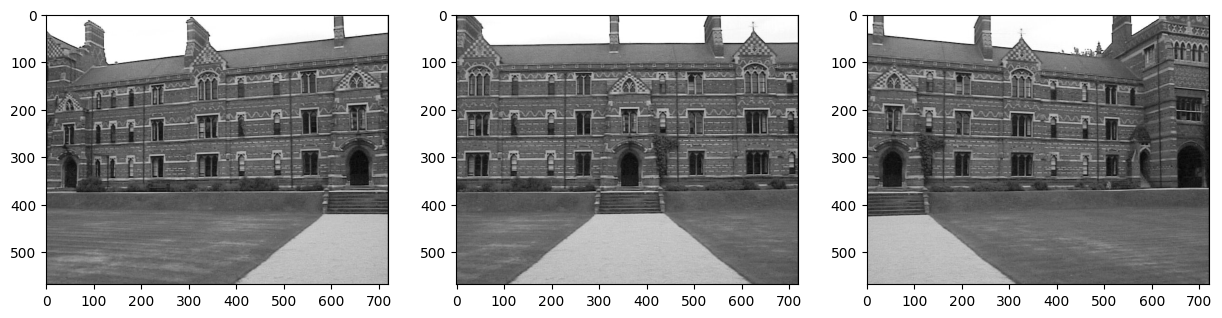

In [44]:
img1 = cv2.imread('img/keble_a.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('img/keble_b.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img3 = cv2.imread('img/keble_c.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,3,figsize=(15,15))

ax[0].imshow(img1, cmap="gray")
ax[1].imshow(img2, cmap="gray")
ax[2].imshow(img3, cmap="gray")

In [27]:
def extract_patch_center(image, center, patch_size=100):
    """
    Extracts a patch from the given image centered around the specified coordinates.

    Args:
        image (numpy.ndarray): The input image.
        center (tuple): The coordinates (y, x) of the center of the patch.
        patch_size (int, optional): The size of the patch. Defaults to 100.

    Returns:
        numpy.ndarray or None: The extracted patch if it is within the image boundaries, otherwise None.
    """
    y_center, x_center = center
    half = patch_size // 2

    ymin = y_center - half
    ymax = y_center + half

    xmin = x_center - half
    xmax = x_center + half

    if (ymin < 0) or (x_center - half < 0) or (xmin >= image.shape[0]) or (xmax >= image.shape[1]):
        return None
    
    else:
        return image[ymin:ymax, xmin:xmax]


def get_max_corners(img, window_size=5, maxCorners=100):
    """
    Returns the maximum corners detected in the input image using the Harris Corner Detector and Non-Maximal Suppression.

    Parameters:
    img (numpy.ndarray): The input image.
    window_size (int): The size of the window used for corner detection. Default is 5.
    maxCorners (int): The maximum number of corners to be detected. Default is 100.

    Returns:
    numpy.ndarray: The maximum corners detected in the image.
    """

    img_ = img.copy()

    h_corners = HarrisCornerDetector(img_, window_size)
    max_corners = NonMaximalSupression(h_corners, window_size=window_size, maxCorners=maxCorners)

    return max_corners


def get_matches(img1, img2, window_size=10, maxCorners=100, patch_size=100):
    """
    Finds matching points between two images using correlation coefficient.

    Args:
        img1 (numpy.ndarray): The first input image.
        img2 (numpy.ndarray): The second input image.
        window_size (int, optional): The size of the window for corner detection. Defaults to 10.
        maxCorners (int, optional): The maximum number of corners to detect. Defaults to 100.
        patch_size (int, optional): The size of the patch for correlation calculation. Defaults to 100.

    Returns:
        list: A list of matching points between the two images.

    """

    max1 = get_max_corners(img1, window_size, maxCorners)
    max2 = get_max_corners(img2, window_size, maxCorners)

    matches = []
    for p1, point1 in enumerate(max1):

        patch_1 = extract_patch_center(img1, point1, patch_size)
        max_score = 0
        cur_max = None

        if patch_1 is not None:

            for p2, point2 in enumerate(max2):

                patch_2 = extract_patch_center(img2, point2, patch_size)

                if patch_1 is not None and patch_2 is not None:

                    score = np.corrcoef(patch_1.flatten(), patch_2.flatten())[0, 1]

                    if max_score < score:
                        max_score = score
                        cur_max = (max1[p1], max2[p2], score)

            matches.append(cur_max)

    # sort by score
    matches = sorted(matches, key=lambda x: x[2], reverse=True)
    matches = [[i[0], i[1]] for i in matches]

    return matches

We start by finding the matches between image 1 and 2:

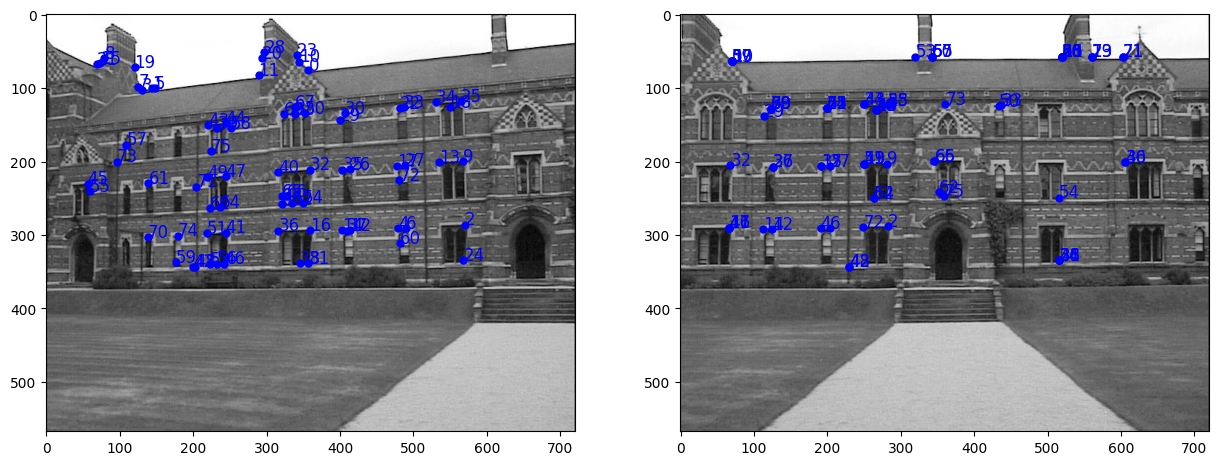

In [29]:
matches_12 = get_matches(img1,img2,window_size=5)
fig, ax = plt.subplots(1,2,figsize=(15,15))

ax[0].imshow(img1, cmap="gray")
ax[1].imshow(img2, cmap="gray")

for num, match in enumerate(matches_12):

    (x1, y1), (x2, y2) = match
    
    ax[0].plot(y1, x1, 'bo', markersize=5)
    ax[1].plot(y2, x2, 'bo', markersize=5)
    
    ax[0].text(y1, x1, s=num, color="blue", fontsize=12)
    ax[1].text(y2, x2, s=num, color="blue", fontsize=12)
    
plt.show()

Then, image 2 and 3:

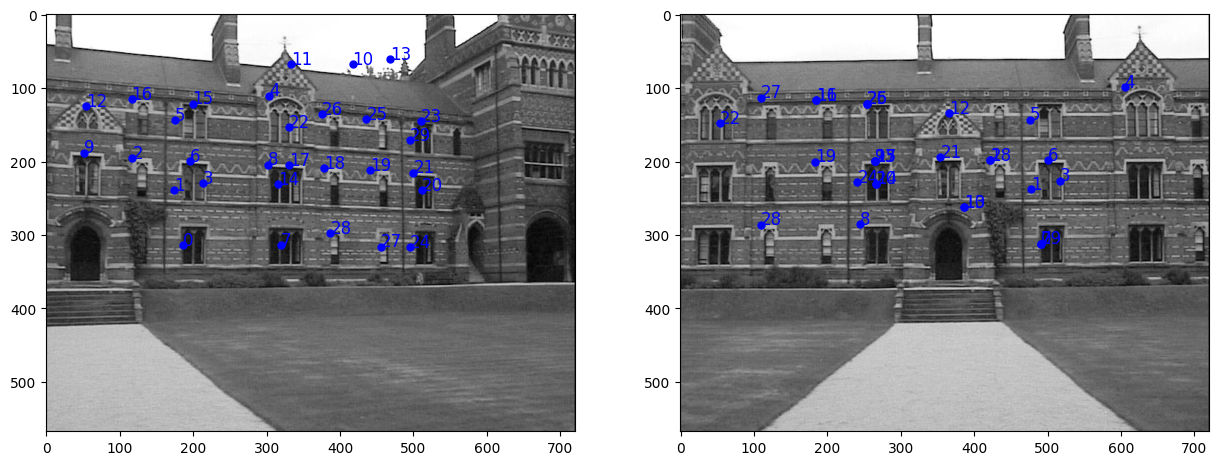

In [182]:
matches_23 = get_matches(img3,img2,window_size=30)

fig, ax = plt.subplots(1,2,figsize=(15,15))
    
ax[1].imshow(img2, cmap="gray")
ax[0].imshow(img3, cmap="gray")

for num, match in enumerate(matches_23):

    (x1, y1), (x2, y2) = match
    
    ax[0].plot(y1, x1, 'bo', markersize=5)
    ax[1].plot(y2, x2, 'bo', markersize=5)

    ax[0].text(y1, x1, s=num, color="blue", fontsize=12)
    ax[1].text(y2, x2, s=num, color="blue", fontsize=12)
    
plt.show()

## RANSAC

Next, we use RANSAC method to find the best homography to correct perspective of the images 2 and 3.

In [222]:
def compute_homography(src_pts, dst_pts):
    """
    Compute the homography matrix using the given source and destination points.

    Parameters:
    src_pts (list of tuples): List of source points [(x1, y1), (x2, y2), ...].
    dst_pts (list of tuples): List of destination points [(x1, y1), (x2, y2), ...].

    Returns:
    H (numpy.ndarray): The computed homography matrix of shape (3, 3).
    """

    A = []

    for (x1, y1), (x2, y2) in zip(src_pts, dst_pts):
        A.append([-x1, -y1, -1, 0, 0, 0, x1 * x2, y1 * x2, x2])
        A.append([0, 0, 0, -x1, -y1, -1, x1 * y2, y1 * y2, y2])

    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))

    return H


def ransac_homography(points1, points2, iterations=1000, tolerance=10):
    """
    Applies the RANSAC algorithm to estimate the homography matrix between two sets of points.

    Parameters:
    - points1 (ndarray): Array of shape (N, 2) representing the first set of points.
    - points2 (ndarray): Array of shape (N, 2) representing the second set of points.
    - iterations (int): Number of iterations to perform RANSAC. Default is 1000.
    - tolerance (float): Maximum distance allowed between the projected points and the actual points to consider them as inliers. Default is 10.

    Returns:
    - best_H (ndarray): The estimated homography matrix.

    """

    best_H = None
    max_inliers = 0
    
    for _ in range(iterations):

        idx = np.random.choice(len(points1), 4, replace=False)
        H = compute_homography(points1[idx], points2[idx])

        points1_homog = np.concatenate((points1, np.ones((points1.shape[0], 1))), axis=1)
        projected_points2_homog = np.dot(points1_homog, H.T)
        projected_points2 = projected_points2_homog[:, :2] / projected_points2_homog[:, 2][:, np.newaxis]
        
        # Calcular o erro e contar os inliers
        errors = np.linalg.norm(points2 - projected_points2, axis=1)
        inliers = errors < tolerance
    
        num_inliers = np.sum(inliers)
        
        if num_inliers > max_inliers:
            # print(max_inliers)

            max_inliers = num_inliers
            best_H = H
    
    return best_H


def get_points(matchs_list):
    src_pts = np.float32([match[0][::-1]  for match in matchs_list])
    dst_pts = np.float32([match[1][::-1]  for match in matchs_list])
    return src_pts, dst_pts


def get_homography(matchs_list, iterations=1000, tolerance=10):
    p1, p2 = get_points(matchs_list)
    H = ransac_homography(p1, p2, iterations, tolerance)
    return H

Questão 4:

In [289]:
def get_img_warped(img, H, match_points):
    """
    Applies a perspective transformation to an image and returns the warped image, corrected homography matrix,
    and corrected match points.

    Args:
        img (numpy.ndarray): The input image.
        H (numpy.ndarray): The homography matrix.
        match_points (list): The list of match points.

    Returns:
        img_warped (numpy.ndarray): The warped image.
        H_corrected (numpy.ndarray): The corrected homography matrix.
        corrected_match_p (numpy.ndarray): The corrected match points.
    """
    #encontrar a transformacao dos cantos da imagem
    h, w = img.shape
    corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    
    transformed_corners = cv2.perspectiveTransform(corners, H)

    # Encontrar os limites da imagem transformada
    [x_min, y_min] = np.int32(transformed_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(transformed_corners.max(axis=0).ravel()  + 0.5)

    # Ajustar a matriz de homografia para a translação
    H_translation = np.array([[1, 0, -x_min],
                            [0, 1, -y_min],
                            [0, 0, 1]])

    # Aplicar a translação na matriz de homografia
    H_corrected = H_translation @ H

    # Aplicar a transformação
    output_shape = (int(x_max - x_min), int(y_max - y_min))
    img_warped = cv2.warpPerspective(img, H_corrected, output_shape)

    #match points
    img_p = np.array( match_points, dtype='float32')
    corrected_match_p = cv2.perspectiveTransform( np.expand_dims(img_p, axis=0), H_corrected)[0]

    return img_warped, H_corrected, corrected_match_p

Now, we apply the method to the images:

In [290]:
img1 = cv2.imread('img/keble_a.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('img/keble_b.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img3 = cv2.imread('img/keble_c.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

[[ 3.36430654e-03 -4.99984832e-05 -9.85717648e-01]
 [ 3.22657624e-04  3.24749601e-03 -1.68320062e-01]
 [ 9.40337419e-07  2.90520786e-07  2.66522336e-03]]


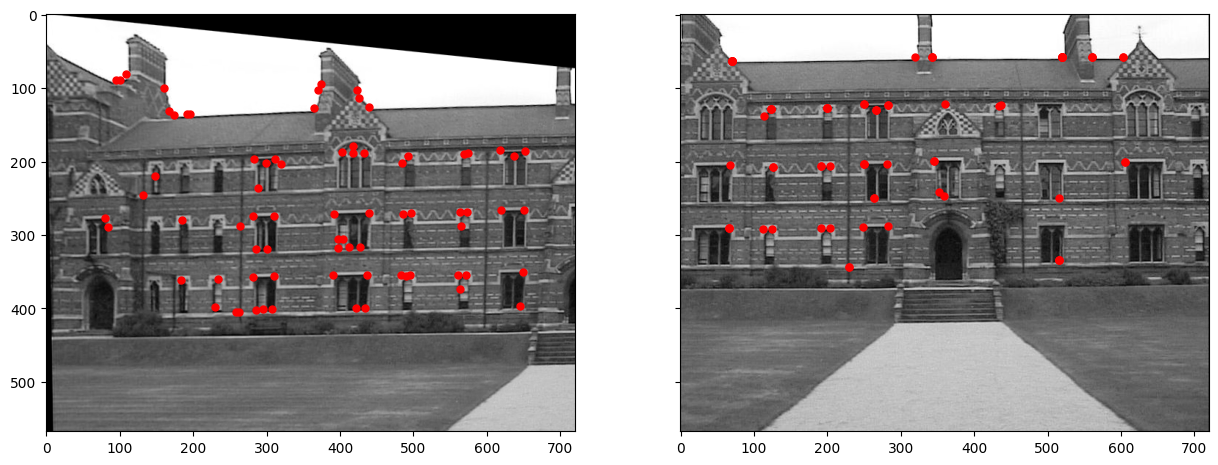

In [291]:
H_12 = get_homography(matches_12[:20],tolerance=10)
print(H_12)

match1_p, match2_p = get_points(matches_12)
img_warped1, H_adj_12, img_points12 = get_img_warped(img1,H_12,match1_p)

fig, ax = plt.subplots(1,2,figsize=(15,15),sharex=True,sharey=True)

ax[0].plot(img_points12[:,0], img_points12[:,1], 'o', color='red', markersize=5)
ax[1].plot(match2_p[:,0], match2_p[:,1], 'o', color='red', markersize=5)

ax[0].imshow(img_warped1, cmap="gray")
ax[1].imshow(img2, cmap="gray")

[[-2.15971100e-03 -1.44727004e-05 -9.95844557e-01]
 [ 4.24234939e-04 -2.79906690e-03 -9.09451166e-02]
 [ 1.33179657e-06  1.49632072e-07 -3.15028973e-03]]


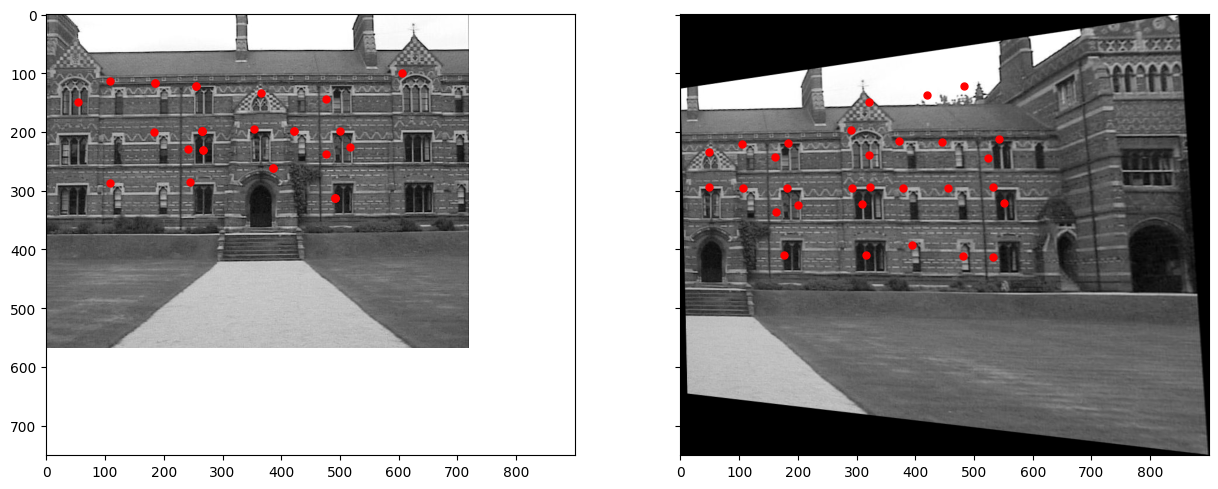

In [292]:
H_23 = get_homography(matches_23)
print(H_23)

points3_match2, points2_match3 = get_points(matches_23)
img_warped3, H_adj_32, img_points32 = get_img_warped(img3,H_23,points3_match2)

fig, ax = plt.subplots(1,2,figsize=(15,15),sharex=True,sharey=True)

ax[0].plot(points2_match3[:,0], points2_match3[:,1], 'o', color='red', markersize=5)
ax[1].plot(img_points32[:,0], img_points32[:,1], 'o', color='red', markersize=5)

ax[0].imshow(img2, cmap="gray")

ax[1].imshow(img_warped3, cmap="gray")

Finally, we'll join all three images:

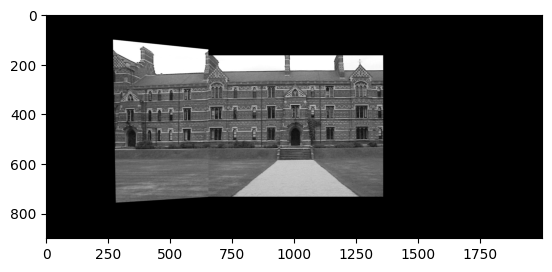

In [417]:
background_size = (900, 2000)
blank_image = np.zeros(background_size, dtype=np.float32) 

#image 2
y_offset = (background_size[0] - img2.shape[0]) // 2
x_offset = (background_size[1] - img2.shape[1]) // 2

blank_image[y_offset:y_offset + img2.shape[0], x_offset:x_offset + img2.shape[1]] = img2

# add image 1
new_point0 = [x_offset + match2_p[0][0],y_offset + match2_p[0][1] ] #calcula aonde esta o ponto de match na imagem 2 na imagem nova

translacao_img1 =  np.array([[1, 0, new_point0[0] - img_points12[0][0]],
                            [0, 1, new_point0[1] - img_points12[0][1]],
                            [0, 0, 1]])

#apply transformation to image 1
new_img1 = cv2.warpPerspective( img_warped1, translacao_img1, img_warped1.shape)
blank_image[:new_img1.shape[0], :new_img1.shape[1]] = new_img1

plt.imshow(blank_image,cmap='grey')

Now we join the new image to the image 3:

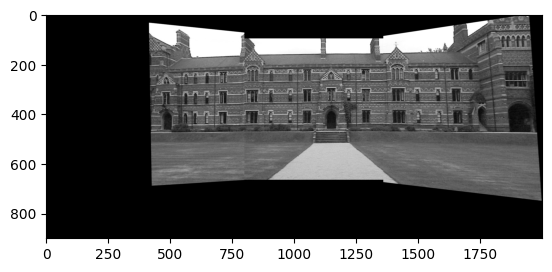

In [418]:
new_point1 = [x_offset + points2_match3[0][0],y_offset + points2_match3[0][1] ] 


blank_image2 = np.zeros(background_size, dtype=np.float32) 

y_offset_img3 = 0
x_offset_img3 = background_size[1] - img_warped3.shape[1]  

blank_image2[y_offset_img3:y_offset_img3 + img_warped3.shape[0],
             x_offset_img3:x_offset_img3 + img_warped3.shape[1]] = img_warped3

ref_point_img3 = [x_offset_img3 + img_points32[0][0],  img_points32[0][1] ]

translacao_img3 =  np.array([[1, 0, ref_point_img3[0] - new_point1[0]],
                            [0, 1, ref_point_img3[1] - new_point1[1]],
                            [0, 0, 1]])

new_img1 = cv2.warpPerspective( blank_image, translacao_img3, blank_image.shape[::-1])


blank_image[y_offset:y_offset + img2.shape[0], x_offset:x_offset + img2.shape[1]] = img2
blank_image2[:y_offset + img2.shape[0], :x_offset + img2.shape[1]] = new_img1[:y_offset + img2.shape[0], :x_offset + img2.shape[1]]

plt.imshow(blank_image2,cmap='grey')

Now we just erase all blank space:

In [419]:
def remove_zero_rows_and_columns(arr):
    # Identify rows that are not all zeros
    non_zero_rows = np.any(arr != 0, axis=1)
    
    # Identify columns that are not all zeros
    non_zero_cols = np.any(arr != 0, axis=0)
    
    # Filter out rows and columns that are all zeros
    filtered_arr = arr[non_zero_rows][:, non_zero_cols]
    
    return filtered_arr

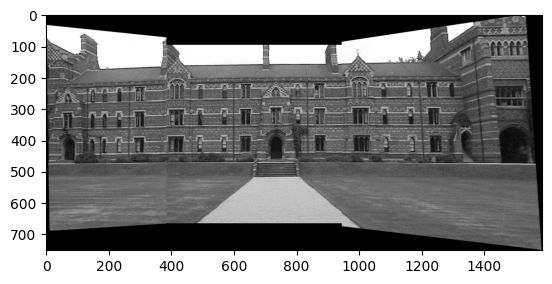

In [422]:
plt.imshow(remove_zero_rows_and_columns(blank_image2), cmap='grey')